# Import and Set up

In [22]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random
import time
import os
import subprocess
import requests
import glob

In [23]:
np.random.seed(42)

In [24]:
def download_file(url, save_path):
    if not os.path.exists(save_path):
        subprocess.run(['wget', url, '-O', save_path, '-q'])

In [25]:
inference_dir = 'inference_data'
os.makedirs(inference_dir, exist_ok=True)

# Model

## using a pre trained model

In [40]:
# get the pretrained model from torchvision.models
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(
    weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT
)
_ = model.eval()

 # These are the classes that are available in the COCO-Dataset
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))

## utility functions

In [41]:
# Assign a color to each detected object mask for visualization
def random_color_masks(image, colors):
    """
    Assigns a random color to each predicted object mask.

    Parameters:
        image (numpy.ndarray): Binary mask where detected object pixels are 1.
        colors (list): List of available colors for masks.

    Returns:
        numpy.ndarray: Colored mask of the same shape as the input.
    """
    # Create empty color channels
    r, g, b = np.zeros_like(image, dtype=np.uint8), np.zeros_like(image, dtype=np.uint8), np.zeros_like(image, dtype=np.uint8)

    # Assign a random color to the mask
    r[image == 1], g[image == 1], b[image == 1] = colors[random.randint(0, len(colors) - 1)]

    # Stack the channels to create a colored mask
    return np.stack([r, g, b], axis=2)

In [42]:
# Get predictions (masks, bounding boxes, and class labels) from the model
def get_prediction(img_path, threshold):
    """
    Performs object instance segmentation on an image.

    Parameters:
        img_path (str): Path to the input image.
        threshold (float): Confidence threshold for filtering predictions.

    Returns:
        tuple: (masks, bounding boxes, class labels)
    """
    # Load image using PIL
    img = Image.open(img_path)

    # Convert image to a PyTorch tensor
    img_tensor = T.ToTensor()(img)

    # Perform inference with the model in no-grad mode to save memory
    with torch.no_grad():
        pred = model([img_tensor])

    # Extract predictions and convert to NumPy arrays
    pred_data = pred[0]
    scores = pred_data['scores'].detach().cpu().numpy()
    labels = pred_data['labels'].detach().cpu().numpy()
    boxes = pred_data['boxes'].detach().cpu().numpy()
    masks = (pred_data['masks'] > 0.5).squeeze().detach().cpu().numpy()

    # Get index of last prediction above the threshold
    valid_indices = scores > threshold
    if not np.any(valid_indices):
        return [], [], []

    # Select predictions that meet the confidence threshold
    pred_boxes = [[(b[0], b[1]), (b[2], b[3])] for b in boxes[valid_indices]]
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in labels[valid_indices]]
    masks = masks[valid_indices]

    return masks, pred_boxes, pred_class

In [43]:
# Perform instance segmentation and visualize the result
def instance_segmentation_api(img_path, threshold=0.5):
    """
    Performs instance segmentation on an image and displays the result.

    Parameters:
        img_path (str): Path to the input image.
        threshold (float, optional): Minimum confidence score for valid predictions. Defaults to 0.5.
    """
    # Get segmentation predictions
    masks, boxes, pred_cls = get_prediction(img_path, threshold)

    # Load the image using OpenCV and convert from BGR to RGB
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Calculate rectangle and text thickness based on image size
    rect_th = max(round(sum(img.shape) / 2 * 0.003), 2)
    text_th = max(rect_th - 1, 1)

    # Iterate over detected objects
    for i in range(len(masks)):
        # Get bounding box coordinates
        p1, p2 = (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1]))

        # Generate a random color mask for the object
        rgb_mask = random_color_masks(masks[i], COLORS)

        # Blend mask with original image using weighted sum
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)

        # Select bounding box color based on object class
        color = COLORS[COCO_INSTANCE_CATEGORY_NAMES.index(pred_cls[i])]

        # Draw bounding box around the detected object
        cv2.rectangle(img, p1, p2, color=color, thickness=rect_th)

        # Get text size for label display
        w, h = cv2.getTextSize(pred_cls[i], 0, fontScale=rect_th / 3, thickness=text_th)[0]
        outside = p1[1] - h >= 3  # Determine whether label should be inside or outside box
        p2 = (p1[0] + w, p1[1] - h - 3) if outside else (p1[0] + w, p1[1] + h + 3)

        # Draw filled rectangle as background for the class label
        cv2.rectangle(img, p1, p2, color=color, thickness=-1, lineType=cv2.LINE_AA)

        # Overlay the object class label on the image
        cv2.putText(
            img,
            pred_cls[i],
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            rect_th / 3,
            (255, 255, 255),
            thickness=text_th + 1
        )

    # Display the final image with masks and bounding boxes
    plt.figure(figsize=(20, 17))
    plt.imshow(img)
    plt.axis("off")  # Hide axis labels
    plt.show()

# Inference

## person

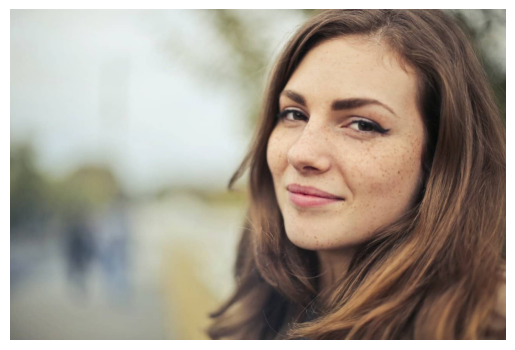

In [44]:
# Download the image and plotting it
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/person-1.jpg',
    os.path.join(inference_dir, 'person.jpg')
)

img = Image.open(os.path.join(inference_dir, 'person.jpg'))
plt.imshow(img)
plt.axis('off')
plt.show()

In [45]:
# run inference
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)
with torch.inference_mode():
    pred = model([img_tensor])

pred[0]

{'boxes': tensor([[ 431.6028,    2.4547, 1280.0001,  851.2910],
         [ 119.3283,   43.6911,  862.8618,  853.0000]]),
 'labels': tensor([1, 1]),
 'scores': tensor([0.9998, 0.1074]),
 'masks': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0013, 0.0013, 0.0012],
           [0.0000, 0.0000, 0.0000,  ..., 0.0014, 0.0014, 0.0013],
           [0.0000, 0.0000, 0.0000,  ..., 0.0015, 0.0015, 0.0014],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.1385, 0.1310, 0.1234],
           [0.0000, 0.0000, 0.0000,  ..., 0.1301, 0.1230, 0.1159],
           [0.0000, 0.0000, 0.0000,  ..., 0.1216, 0.1150, 0.1083]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0

In [46]:
# We will keep only the pixels with values  greater than 0.5 as 1, and set the rest to 0.
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
masks.shape

(2, 853, 1280)

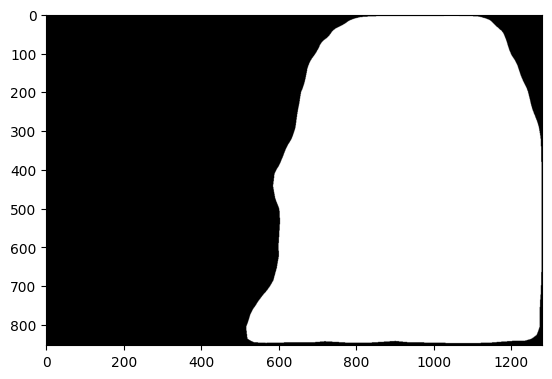

In [47]:
# Let's plot the mask for the `person` class since the 0th mask belongs to `person`
plt.imshow(masks[0], cmap='gray')
plt.show()

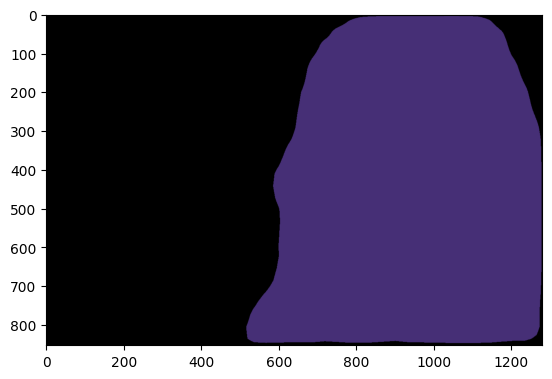

In [48]:
# Let's color the `person` mask using the `random_color_masks` function
mask1 = random_color_masks(masks[0], COLORS)
plt.imshow(mask1)
plt.show()

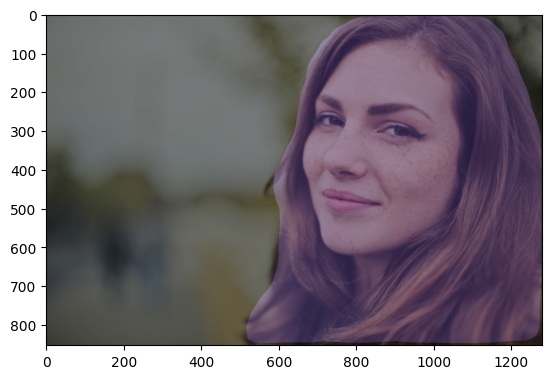

In [49]:
# Let's blend the original and the masked image and plot it.
blend_img = cv2.addWeighted(np.asarray(img), 0.5, mask1, 0.5, 0)

plt.imshow(blend_img)
plt.show()

## group of people

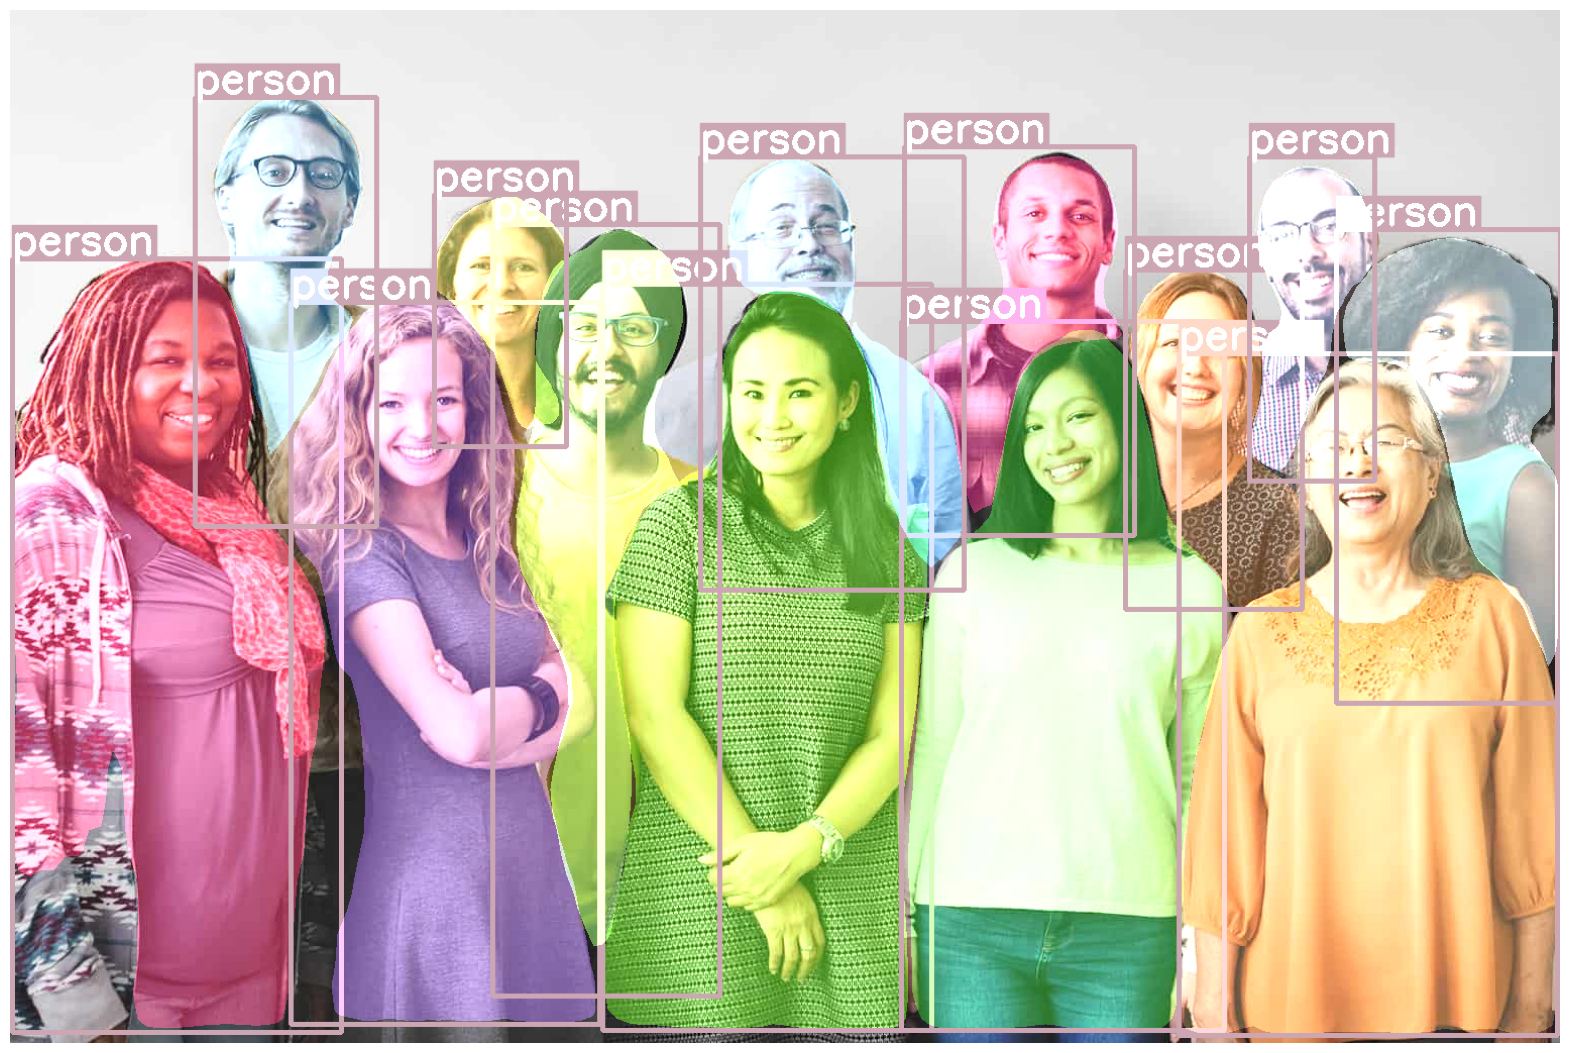

In [50]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/mrcnn_standing_people.jpg',
    os.path.join(inference_dir, 'mrcnn_standing_people.jpg')
)
instance_segmentation_api(os.path.join(inference_dir, 'mrcnn_standing_people.jpg'), 0.75)

## cars

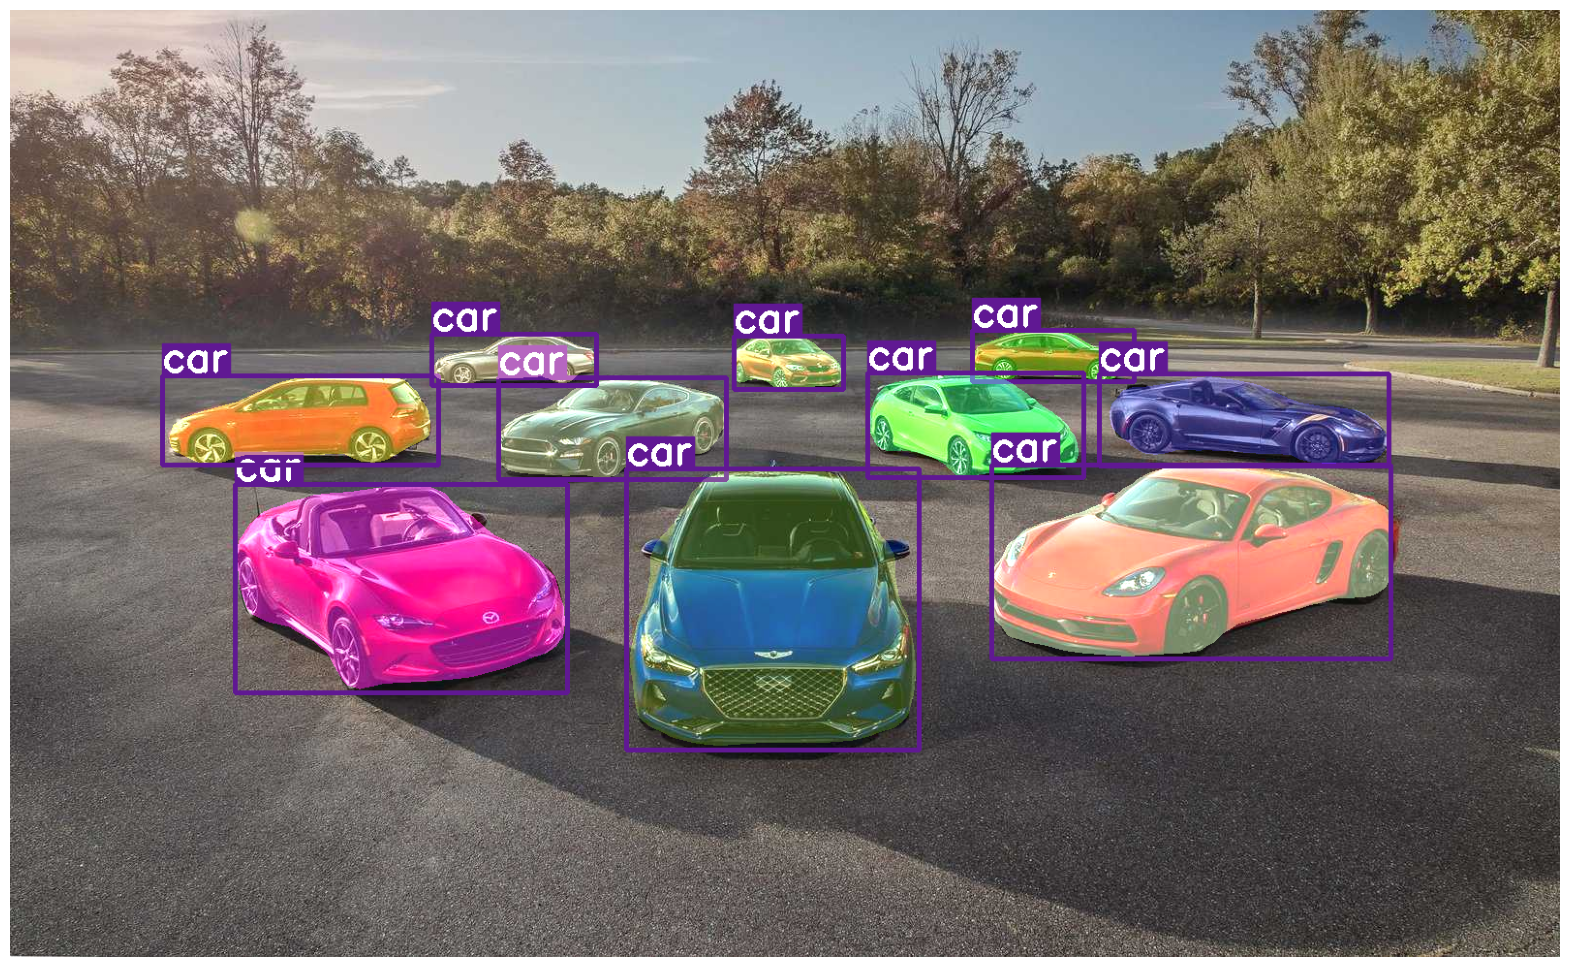

In [51]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/mrcnn_cars-scaled.jpg',
    os.path.join(inference_dir, 'mrcnn_cars.jpg')
)
instance_segmentation_api(os.path.join(inference_dir, 'mrcnn_cars.jpg'), 0.9)












## traffic

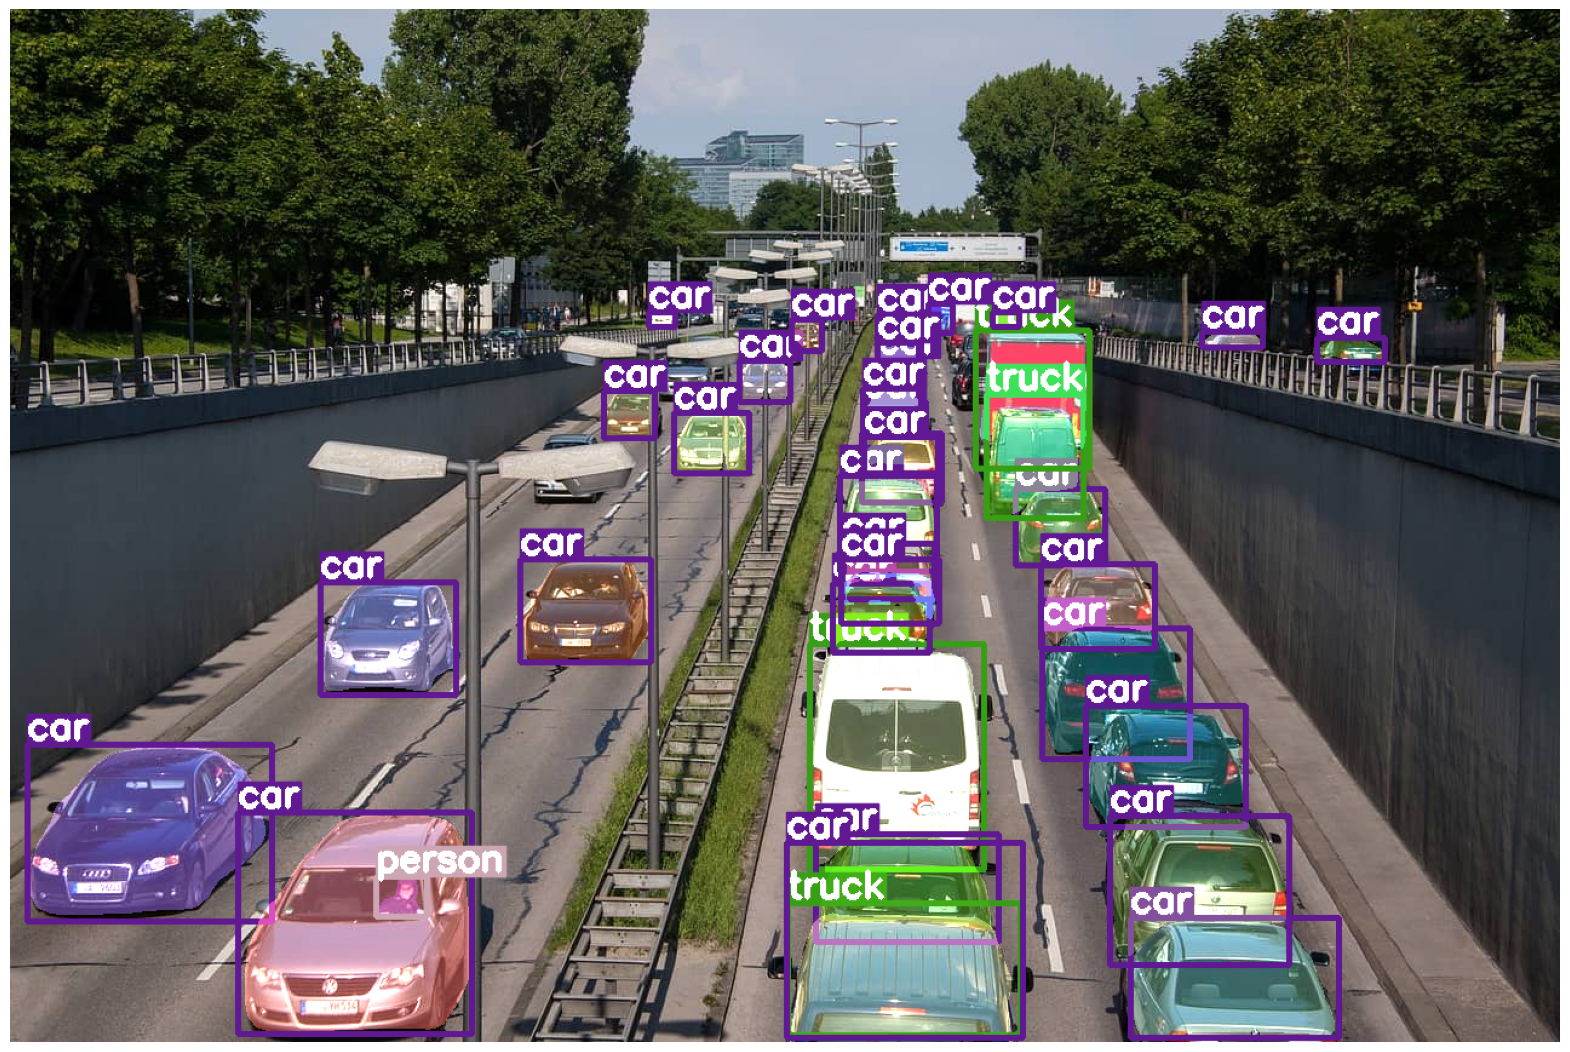

In [52]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/mrcnn-traffic.jpg',
    os.path.join(inference_dir, 'mrcnn-traffic.jpg')
)
instance_segmentation_api(os.path.join(inference_dir, 'mrcnn-traffic.jpg'), 0.6)

# Comparison

In [53]:
# Load model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(
    weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT
)
# Set model on evalution mode
model.eval()

import time

def check_inference_time(image_path, gpu=False):
    """
    Measures the inference time of a model on a given image.

    Parameters:
        image_path (str): Path to the input image.
        gpu (bool, optional): Whether to run inference on GPU. Defaults to False.

    Returns:
        float: Time taken for model inference in seconds.
    """

    # Load image and convert to a PyTorch tensor
    img = T.ToTensor()(Image.open(image_path)).unsqueeze(0)  # Add batch dimension

    # Move model and image to the selected device
    device = torch.device("cuda:0" if gpu and torch.cuda.is_available() else "cpu")
    model.to(device)
    img = img.to(device)

    # Measure inference time
    start_time = time.time()
    with torch.no_grad():  # Disable gradient tracking for faster inference
        model(img)
    return time.time() - start_time  # Return elapsed time

In [54]:
# Let's run inference on all the downloaded images and average their inference time
img_paths = [
    path for path in glob.glob(os.path.join(inference_dir, '*')) \
    if path.split('.')[-1].lower() in ["jpeg", "jpg", "png"]
]

gpu_times = []
cpu_times = []

for img_path in img_paths:
    gpu_time = check_inference_time(img_path, gpu=True)
    gpu_times.append(gpu_time)

gpu_time = sum([check_inference_time(img_path, gpu=True) for img_path in img_paths])/len(img_paths)
cpu_time = sum([check_inference_time(img_path, gpu=False) for img_path in img_paths])/len(img_paths)

print('\n\nAverage Time take by the model with GPU = {}s\nAverage Time take by the model with CPU = {}s'.format(gpu_time, cpu_time))



Average Time take by the model with GPU = 0.1355699896812439s
Average Time take by the model with CPU = 9.73730844259262s
